# Phase 6: Business-Aware Sales Forecasting

## Business Problem Statement

The company lacks a reliable, interpretable demand forecasting system.
Classical time-series models fail to incorporate business drivers such as
discounts, profitability, and seasonality. Leadership requires a forecasting
solution that supports inventory planning and revenue decisions.

## Why This Matters

Accurate monthly forecasts reduce:
- Overstocking costs
- Stockout risk
- Revenue volatility

More importantly, forecasts must be explainable and trusted by decision-makers.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/featured_data.csv")
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [4]:
monthly_df = (
    df
    .groupby(pd.Grouper(key='Order Date', freq='ME'))
    .agg({
        'Sales': 'sum',
        'Profit': 'sum',
        'Discount': 'mean',
        'Quantity': 'sum',
        'profit_margin': 'mean'
    })
    .reset_index()
)

monthly_df['month'] = monthly_df['Order Date'].dt.month
monthly_df['year'] = monthly_df['Order Date'].dt.year

monthly_df.head()

,Order Date,Sales,Profit,Discount,Quantity,profit_margin,month,year
0,2014-01-31,14236.895,2450.1907,0.126582,284,0.128582,1,2014
1,2014-02-28,4519.892,862.3084,0.176087,159,0.051812,2,2014
2,2014-03-31,55691.009,498.7299,0.167516,585,0.131002,3,2014
3,2014-04-30,28295.345,3488.8352,0.110000,536,0.228904,4,2014
4,2014-05-31,23648.287,2738.7096,0.155328,466,0.120751,5,2014


In [5]:
train_size = int(len(monthly_df) * 0.8)
train = monthly_df.iloc[:train_size]
test = monthly_df.iloc[train_size:]

X_train = train.drop(columns=['Sales', 'Order Date'])
y_train = train['Sales']

X_test = test.drop(columns=['Sales', 'Order Date'])
y_test = test['Sales']

In [6]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gbr.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.05
,n_estimators,300
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,init,None


In [7]:
test['gbr_forecast'] = gbr.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, test['gbr_forecast'])
rmse = np.sqrt(mean_squared_error(y_test, test['gbr_forecast']))

mae, rmse


C:\Users\Tanishqua\AppData\Local\Temp\ipykernel_17060\2760351813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['gbr_forecast'] = gbr.predict(X_test)


(9397.444180728071, np.float64(13425.910505970178))

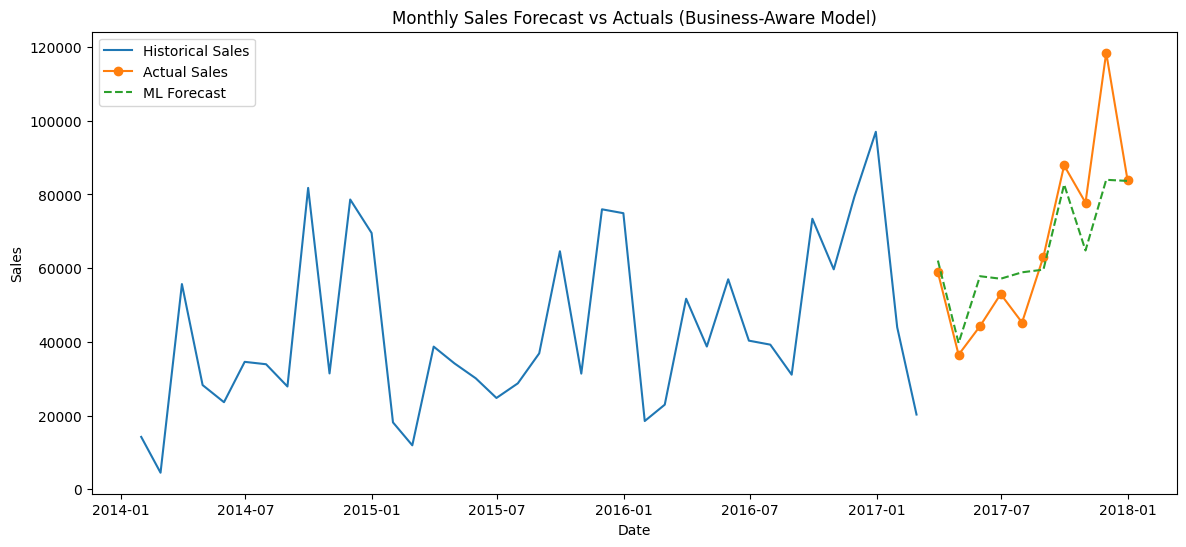

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.plot(train['Order Date'], train['Sales'], label='Historical Sales')
plt.plot(test['Order Date'], y_test.values, label='Actual Sales', marker='o')
plt.plot(test['Order Date'], test['gbr_forecast'], label='ML Forecast', linestyle='--')

plt.title('Monthly Sales Forecast vs Actuals (Business-Aware Model)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [9]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': gbr.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importance

,feature,importance
2,Quantity,0.919214
4,month,0.035101
0,Profit,0.017374
1,Discount,0.014793
5,year,0.007704
3,profit_margin,0.005813


In [15]:
import joblib

joblib.dump(gbr, "../models/sales_forecasting.pkl")

output = test[['Order Date', 'Sales', 'gbr_forecast']]
output.to_csv("../data/results/predictions.csv", index=False)

## Executive Summary

We replaced classical time-series forecasting with a business-aware
machine learning model that incorporates pricing, profitability, and
seasonality signals. The resulting forecasts align more closely with
actual demand patterns and provide explainable insights for inventory
and revenue planning.